In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
# Remove padding around screen

from IPython.core.display import display, HTML

import numpy as np

from os import walk
import tensorflow as tf,numpy,keras,PIL
from PIL import Image

import sys
from os.path import dirname
sys.path.append("/home/jason/sproj/donkeycar")

import donkeycar as dk
import donkeycar.parts.datastore as datastore

import keras

import donkeycar as dk
#import parts
from donkeycar.utils import linear_unbin
from donkeycar.parts.camera import PiCamera
from donkeycar.parts.transform import Lambda
from donkeycar.parts.keras import KerasCategorical, KerasRNN_LSTM, KerasRNN_Categorical, KerasHresCategorical, KerasLinear

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


using donkey v2.2.1 ...


Using TensorFlow backend.


In [2]:
tub2 = datastore.TubGroup('/home/jason/sproj/datasets/8track/data-4-4/data/*')

TubGroup:tubpaths: ['/home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-15', '/home/jason/sproj/datasets/8track/data-4-4/data/tub_3_18-04-03', '/home/jason/sproj/datasets/8track/data-4-4/data/tub_5_18-04-04', '/home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-04', '/home/jason/sproj/datasets/8track/data-4-4/data/tub_2_18-04-03']
path_in_tub: /home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-15
Tub exists: /home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-15
path_in_tub: /home/jason/sproj/datasets/8track/data-4-4/data/tub_3_18-04-03
Tub exists: /home/jason/sproj/datasets/8track/data-4-4/data/tub_3_18-04-03
path_in_tub: /home/jason/sproj/datasets/8track/data-4-4/data/tub_5_18-04-04
Tub exists: /home/jason/sproj/datasets/8track/data-4-4/data/tub_5_18-04-04
path_in_tub: /home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-04
Tub exists: /home/jason/sproj/datasets/8track/data-4-4/data/tub_7_18-04-04
path_in_tub: /home/jason/sproj/datasets/8track

# Loading the data
Donkeycar stores all the data in groups referred to as 'tubs'. These tubs consist of records and images.

This next section loads the datastores, and returns the number of records(images+steering angles) inside the tubs

## Steering Angle Histogram
Create the distribution of steering angles for the 8 track.

In [3]:
tub2.df.shape

(59190, 4)

Text(0,0.5,'# of Steering Requested')

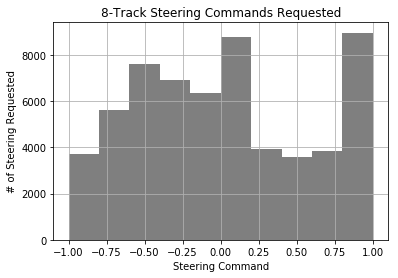

In [6]:
plot = tub2.df['user/angle'].hist(alpha=0.5,color='black')
plot.set_title('8-Track Steering Commands Requested')
plot.set_xlabel('Steering Command')
plot.set_ylabel('# of Steering Requested')

In [15]:
ltracktub = datastore.Tub("~/sproj/datasets/ltrack/data-4-9/tub_5_18-04-10")
#b = datastore.Tub("../datasets/8track/data-4-4/data/tub_6_18-04-04/")

path_in_tub: /home/jason/sproj/datasets/ltrack/data-4-9/tub_5_18-04-10
Tub exists: /home/jason/sproj/datasets/ltrack/data-4-9/tub_5_18-04-10


14727


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


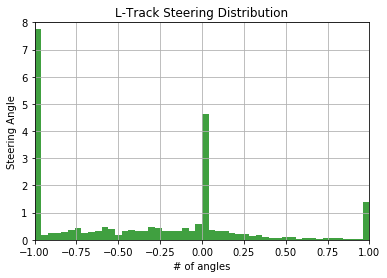

In [19]:
import matplotlib.mlab as mlab
print(ltracktub.get_num_records())
x = []
for i in range(4040,ltracktub.get_num_records()):
    record = ltracktub.get_record(i)
    x.append(record['user/angle'])
    
'''for i in range(4040,ltracktub.get_num_records()):
    record = ltracktub.get_record(i)
    x.append(-1*record['user/angle'])
    '''


mu, sigma = 100, 15
#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('# of angles')
plt.ylabel('Steering Angle')
plt.title(r'L-Track Steering Distribution')
plt.axis([-1, 1, 0, 8])
plt.grid(True)

plt.show()

# Model Evaluation
The metrics below loads the testing tub, and calculates the mean squared error of each model.

In [2]:
circuit_test = datastore.Tub("~/sproj/datasets/circuit/circuit_test1")
print(circuit_test.get_num_records())

path_in_tub: /home/jason/sproj/datasets/circuit/circuit_test1
Tub exists: /home/jason/sproj/datasets/circuit/circuit_test1
4820


In [3]:
eighttracktest = datastore.Tub("~/sproj/datasets/8track/data-4-4/testing/")
print(eighttracktest.get_num_records())

circuit_test = eighttracktest

path_in_tub: /home/jason/sproj/datasets/8track/data-4-4/testing/
Tub exists: /home/jason/sproj/datasets/8track/data-4-4/testing/
725


### Linear errors

In [4]:
klinear = KerasLinear()
klinear.load('/home/jason/sproj/d2/models/linear/linear_8track2')

In [5]:
errors = []

for i in range(1,circuit_test.get_num_records()):
    record = circuit_test.get_record(i)
    true_angle = (record['user/angle'])
    img_arr = np.asarray(record['cam/image_array'])
    predict_angle = klinear.run(img_arr)[0]
    delta = true_angle-predict_angle
    delta = delta*delta # Square the error
    errors.append(delta)
    
error = sum(errors)/circuit_test.get_num_records()
print("num records: "+str(circuit_test.get_num_records()))
print(error)

num records: 725
0.3013905922198277


In [6]:
linearerrors = errors

### Categorical errors

In [7]:
kl = KerasCategorical()
kl.load('/home/jason/sproj/d2/models/cat/cat_8track1')

In [8]:
errors = []
for i in range(1,circuit_test.get_num_records()):
    record = circuit_test.get_record(i)
    true_angle = (record['user/angle'])
    img_arr = np.asarray(record['cam/image_array'])
    predict_angle = kl.run(img_arr)[0]
    delta = true_angle-predict_angle
    delta = delta*delta # Square the error
    errors.append(delta)
    
caterrors = errors

In [9]:
error = sum(errors)/circuit_test.get_num_records()
print("num records: "+str(circuit_test.get_num_records()))
print(error)

num records: 725
0.32588318085855006


In [10]:
caterrors = errors

## Evaluation of Recurrent Neural Networks
As recurrent neural networks require a sequence, code below shows implementaiton of loading the sequence and testing it

In [11]:
kl = KerasRNN_LSTM()
kl.load('/home/jason/sproj/d2/models/rnn/rnn_8track2')

count = 0

In [12]:
i = 1
errors = []
max_range = circuit_test.get_num_records()-3
#max_range = 1000
while i <= max_range-3:
    a1 = (circuit_test.get_record(i)['cam/image_array'])
    a1 = a1.reshape((1,) + a1.shape)
    
    a2 = (circuit_test.get_record(i+1)['cam/image_array'])
    a2 = a2.reshape((1,) + a2.shape)
    
    a3 = (circuit_test.get_record(i+2)['cam/image_array'])
    a3 = a3.reshape((1,) + a3.shape)
    
    x1 = np.concatenate((a1, a2, a3))
    x1 = x1.reshape((1,) + x1.shape)
    
    true_angle = (circuit_test.get_record(i+2)['user/angle'])
    predict_angle = kl.model.predict(x1)
    delta = true_angle-predict_angle
    delta = delta*delta # Square the error
    count+=1
    i+=1
    errors.append(delta)
sum(errors)/count

array([[0.27651477, 0.29264987]], dtype=float32)

In [13]:
rnnerrors = errors

### RNN Categorical Errors

Now comparing the performance of a binned recurrent neural network

In [14]:
rnncat = KerasRNN_Categorical()
rnncat.load('/home/jason/sproj/d2/models/rnnbin/rnnbin_8track2')

In [15]:
errors = []
count = 0

i = 1
max_range = circuit_test.get_num_records()-3
#max_range = 1000
while i <= max_range-3:
    a1 = (circuit_test.get_record(i)['cam/image_array'])
    a1 = a1.reshape((1,) + a1.shape)
    
    a2 = (circuit_test.get_record(i+1)['cam/image_array'])
    a2 = a2.reshape((1,) + a2.shape)
    
    a3 = (circuit_test.get_record(i+2)['cam/image_array'])
    a3 = a3.reshape((1,) + a3.shape)
    
    x1 = np.concatenate((a1, a2, a3))
    x1 = x1.reshape( x1.shape)
    
    #print(x1.shape)
    
    true_angle = (circuit_test.get_record(i+2)['user/angle'])
    predict_angle = linear_unbin(sum(rnncat.model.predict(x1)[0]))
    '''print('p: '+str(predict_angle))
    print('t: '+str(true_angle))
    print('---')'''
    delta = true_angle-predict_angle
    delta = delta*delta # Square the error
    count+=1
    i+=1
    errors.append(delta)
sum(errors)/count

0.3438165252192672

In [16]:
rnncaterrors = errors


In [17]:
rnnerrors2=[]
for error in rnnerrors:
    rnnerrors2.append(error[0])


## Converting to CSV file for R Data analysis

In [18]:

deviations = {'linear':linearerrors,'categorical':caterrors,
              'rnn':rnnerrors2,'rnncat':rnncaterrors}

for model in deviations:
    print(model)
    a = numpy.asarray(deviations[model])
    numpy.savetxt(model+"-accuracy-circuit.csv", a, delimiter=",")

linear
categorical
rnn
rnncat
